In [1]:
import numpy as np
import math
from sympy import *
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time

In [2]:
def chi2(T):
    p = T[0]; q = T[1]; r = T[2]; s = T[3]; t = T[4]; u = T[5]
    S = 0
    if p+q != 0:
        S += ((p-q)**2)/(p+q)
    if r+s != 0:
        S += ((r-s)**2)/(r+s)
    if t+u != 0:
        S += ((t-u)**2)/(t+u)
    return S

In [3]:
def DOLS_chi2(x,n,m):
    TG = np.zeros((m,6))
    for i in range(m):
        for j in range(n):
            TG[i][int(x[j][i])] += 1
            
    #Step 1
    MCP = np.zeros((m,6)); MCN = np.zeros((m,6)) #MaxChange
    for i in range(m):
        T = TG[i]
        X = chi2(T); MCP[i] = np.zeros(6); MCN[i] = np.zeros(6)
        if T[0] >= 1:
            Y = chi2([T[0]-1, T[1], T[2]+1, T[3], T[4], T[5]])
            MCP[i][0] = max(MCP[i][0], Y-X); MCN[i][0] = max(MCN[i][0], X-Y)
            Y = chi2([T[0]-1, T[1], T[2], T[3], T[4]+1, T[5]])
            MCP[i][0] = max(MCP[i][0], Y-X); MCN[i][0] = max(MCN[i][0], X-Y)
        if T[1] >= 1:
            Y = chi2([T[0], T[1]-1, T[2], T[3]+1, T[4], T[5]])
            MCP[i][1] = max(MCP[i][1], Y-X); MCN[i][1] = max(MCN[i][1], X-Y)
            Y = chi2([T[0], T[1]-1, T[2], T[3], T[4], T[5]+1])
            MCP[i][1] = max(MCP[i][1], Y-X); MCN[i][1] = max(MCN[i][1], X-Y)
        if T[2] >= 1:
            Y = chi2([T[0]+1, T[1], T[2]-1, T[3], T[4], T[5]])
            MCP[i][2] = max(MCP[i][2], Y-X); MCN[i][2] = max(MCN[i][2], X-Y)
            Y = chi2([T[0], T[1], T[2]-1, T[3], T[4]+1, T[5]])
            MCP[i][2] = max(MCP[i][2], Y-X); MCN[i][2] = max(MCN[i][2], X-Y)
        if T[3] >= 1:
            Y = chi2([T[0], T[1]+1, T[2], T[3]-1, T[4], T[5]])
            MCP[i][3] = max(MCP[i][3], Y-X); MCN[i][3] = max(MCN[i][3], X-Y)
            Y = chi2([T[0], T[1], T[2], T[3]-1, T[4], T[5]+1])
            MCP[i][3] = max(MCP[i][3], Y-X); MCN[i][3] = max(MCN[i][3], X-Y)
        if T[4] >= 1:
            Y = chi2([T[0]+1, T[1], T[2], T[3], T[4]-1, T[5]])
            MCP[i][4] = max(MCP[i][4], Y-X); MCN[i][4] = max(MCN[i][4], X-Y)
            Y = chi2([T[0], T[1], T[2]+1, T[3], T[4]-1, T[5]])
            MCP[i][4] = max(MCP[i][4], Y-X); MCN[i][4] = max(MCN[i][4], X-Y)
        if T[5] >= 1:
            Y = chi2([T[0], T[1]+1, T[2], T[3], T[4], T[5]-1])
            MCP[i][5] = max(MCP[i][5], Y-X); MCN[i][5] = max(MCN[i][5], X-Y)
            Y = chi2([T[0], T[1], T[2], T[3]+1, T[4], T[5]-1])
            MCP[i][5] = max(MCP[i][5], Y-X); MCN[i][5] = max(MCN[i][5], X-Y)
    
    #Step 2
    LSS = np.zeros(int(2**m))
    for j in range(n):
        LSJ = np.zeros((m,int(2**m)))
        LSJ[0][0] = MCP[0][int(x[j][0])]; LSJ[0][1] = MCN[0][int(x[j][0])]
        #print(LSJ[0],LSJ[1])
        for i in range(1,m):
            for k in range(2**i):
                LSJ[i][2*k+0] = LSJ[i-1][k] + MCP[i][int(x[j][i])]
                LSJ[i][2*k+1] = LSJ[i-1][k] + MCN[i][int(x[j][i])]
        #print(LSJ)
        for i in range(int(2**m)):
            LSS[i] = max(LSS[i],LSJ[m-1][i])    
        #print(LSS)
        
    #Step 3
    DOLSP = np.zeros(m) #LS^{i+}
    DOLSN = np.zeros(m) #LS^{i-}
    
    for j in range(m):
        for i in range(int(2**m)):
            if int(i/(2**(m-1-j)))%2 == 0:
                DOLSP[j] = max(DOLSP[j], LSS[i])
            else:
                DOLSN[j] = max(DOLSN[j], LSS[i])
    
    return DOLSP, DOLSN

In [4]:
def DOSS_chi2_test(n,m): #epsilon = 20*m
    GS = (4*n/(n+2))*m
    while(1):
        x = np.zeros((n,m))
        for i in range(n):
            x[i] = [random.randrange(6) for j in range(m)]
        DOLSP, DOLSN = DOLS_chi2(x,n,m)
        if math.log(GS/min(DOLSP)) < 2 and math.log(GS/min(DOLSN)) < 2:
            return DOLSP, DOLSN

In [5]:
def h2(z,l):
    return np.sqrt(l)/(math.pi*(z**2+l))

def h3(z,l):
    return (3*np.sqrt(3)*(l**(2/3)))/(4*math.pi*(math.fabs(z)**3+l))

def h4(z,l):
    return (np.sqrt(2)*(l**(3/4)))/(math.pi*(z**4+l))

def h6(z,l):
    return (3*(l**(5/6)))/(2*math.pi*(z**6+l))

def cdf(x,h,l):
    g = lambda z: h(z,l)
    return integrate.quad(g,-oo,x)

def noise(h,l,d): # using inverse transform sampling
    r = np.random.rand()
    q = 1000; z = 10
    for i in range(-50,50):
        if math.fabs(r - cdf(i/5,h,l)[0]) > q:
            z = (i-1)/5
            break
        else:
            q = min(q, math.fabs(r - cdf(i/5,h,l)[0]))
    if d == 0:
        return math.fabs(z)
    elif d == 1:
        return -math.fabs(z)
    
def alpha(k,l,m): #epsilon = 20*m
    return ((l**(1/k))*(20*m))/(2*((k-1)**((k-1)/k)))

In [6]:
def accuracy(n,m,DOLSP,DOLSN): # epsilon = 20*m
    acc = np.zeros((6,4))
    l = [0.5,1,2,3,4,5]
    SS = np.zeros(m); d = np.zeros(m)
    
    for j in range(20):
        for i in range(6):
            for t in range(m):
                if random.random()<0.5:
                    d[t] = 0; SS[t] = DOLSP[j][t]
                else:
                    d[t] = 1; SS[t] = DOLSN[j][t]
                acc[i][0] += math.fabs((SS[t]/alpha(2,l[i],m))*noise(h2,l[i],d[t]))
                acc[i][1] += math.fabs((SS[t]/alpha(3,l[i],m))*noise(h3,l[i],d[t]))
                acc[i][2] += math.fabs((SS[t]/alpha(4,l[i],m))*noise(h4,l[i],d[t]))
                acc[i][3] += math.fabs((SS[t]/alpha(6,l[i],m))*noise(h6,l[i],d[t]))
    return acc/(m*20)

[[0.10343958 0.09058902 0.12386424 0.15808039]
 [0.12708418 0.09059117 0.10687525 0.17138505]
 [0.09471734 0.11784692 0.13522273 0.16947645]
 [0.10042622 0.0904413  0.12911281 0.14375779]
 [0.07846178 0.09956874 0.09233316 0.16764044]
 [0.0873556  0.10413916 0.10394494 0.17312717]]
[[0.14219913 0.12574398 0.18433989 0.17575643]
 [0.12560735 0.07425315 0.0946318  0.15844486]
 [0.12425279 0.12167407 0.10872212 0.16072004]
 [0.15828064 0.0916924  0.12215378 0.17595775]
 [0.13368704 0.0878225  0.08678814 0.15046559]
 [0.10520959 0.06943392 0.09352151 0.15683583]]
[[0.16465534 0.16123131 0.09592241 0.16535076]
 [0.15364412 0.12002173 0.1104813  0.14089681]
 [0.13477236 0.07929106 0.10576407 0.14363602]
 [0.11034894 0.09969935 0.08803801 0.20084728]
 [0.13320267 0.08291862 0.08745354 0.14173395]
 [0.1412209  0.07867556 0.11876996 0.1709795 ]]
[[0.1126968  0.11622164 0.1152219  0.17608284]
 [0.16534647 0.10901167 0.09179905 0.15405142]
 [0.16523021 0.06349829 0.11629499 0.1271903 ]
 [0.080802

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


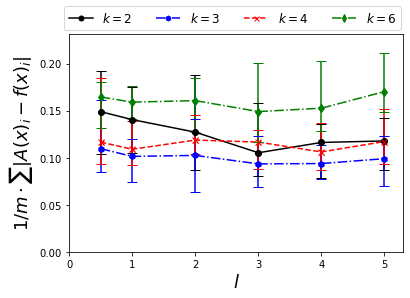

In [7]:
n = 150; m = 2

acc = np.zeros((6,4))
max_acc = np.zeros((6,4)); min_acc = np.ones((6,4))
sum_acc = np.zeros((6,4))

DOLSP = np.zeros((20,m)); DOLSN = np.zeros((20,m))
for i in range(20):
    DOLSP[i], DOLSN[i] = DOSS_chi2_test(n,m)

jj = 10
for j in range(jj):
    acc = accuracy(n,m,DOLSP,DOLSN)
    for i in range(6):
        for k in range(4):
            max_acc[i][k] = max(max_acc[i][k], acc[i][k])
            min_acc[i][k] = min(min_acc[i][k], acc[i][k])
            sum_acc[i][k] += acc[i][k]
    print(acc)
acc = sum_acc/jj

y_err = np.zeros((2,6,4))
for k in range(4):
    y_err[0,:,k] = acc[:,k] - min_acc[:,k]
    y_err[1,:,k] = max_acc[:,k] - acc[:,k]

l = [0.5,1,2,3,4,5]

print(acc)
fig = plt.figure()
plt.ylim(0, max(max_acc[i][j] for i in range(6) for j in range(4))+0.02)
plt.xlim(-0.01, 5.3)
plt.errorbar(l, acc[:,0], yerr = y_err[:,:,0], capsize=5, fmt='o', ecolor='black', markeredgecolor = "black", color='black')
plt.plot(l, acc[:,0], marker="o", markersize=5, color = "black", linestyle = "-", label = "$k = 2$")
plt.errorbar(l, acc[:,1], yerr = y_err[:,:,1], capsize=5, fmt='h', ecolor='blue', markeredgecolor = "blue", color='blue')
plt.plot(l, acc[:,1], marker="h", markersize=5, color = "blue", linestyle = "dashdot", label = "$k = 3$")
plt.errorbar(l, acc[:,2], yerr = y_err[:,:,2], capsize=5, fmt='x', ecolor='red', markeredgecolor = "red", color='red')
plt.plot(l, acc[:,2], marker="x", markersize=5, color = "red", linestyle = "--", label = "$k = 4$")
plt.errorbar(l, acc[:,3], yerr = y_err[:,:,3], capsize=5, fmt='d', ecolor='green', markeredgecolor = "green", color='green')
plt.plot(l, acc[:,3], marker="d", markersize=5, color = "green", linestyle = "dashdot", label = "$k = 6$")
plt.legend(bbox_to_anchor=(0.49, 1.02), loc='lower center', borderaxespad=0, ncol=4, fontsize=12)
plt.xlabel("$l$", fontsize = 18)
plt.ylabel("$1/m \cdot \sum |A(x)_i - f(x)_i|$", fontsize = 18)
fig.savefig("Accuracy_chi2_kl_m=2.png")
fig.savefig("figs/Accuracy_chi2_kl_m=2.eps", bbox_inches="tight", pad_inches=0.05)